### Load Required Libraries

In [1]:
#import libraries
#import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import folium
import matplotlib.pyplot as plt
import re
import urllib.request
from functools import reduce

In [2]:


import plotly.express as px
import plotly.graph_objects as go
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from dash import Dash, dcc, html, Input, Output

## Load Required Data Sets

> #### Load County Shape data

In [3]:
# Read in shapefile
# Downloaded from https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip

county_shape_data = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip")

#Filter to only counties in Illinois using StateFP column = 17
county_shape_data = county_shape_data.loc[(county_shape_data['STATEFP'] == "17")]

county_shape_data.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((-87.91028 38.57493, -87.90811 38.850..."
22,17,093,00424248,0500000US17093,17093,Kendall,06,829468028,5136619,"POLYGON ((-88.60349 41.71358, -88.60193 41.719..."
57,17,139,01784885,0500000US17139,17139,Moultrie,06,870123798,22102741,"POLYGON ((-88.81271 39.74049, -88.75784 39.739..."
74,17,049,00424226,0500000US17049,17049,Effingham,06,1239970330,3183217,"POLYGON ((-88.80532 39.21626, -88.47091 39.215..."
141,17,103,00424253,0500000US17103,17103,Lee,06,1877336056,10634483,"POLYGON ((-89.63147 41.75813, -89.63026 41.843..."


> #### Load Zip Shape data

In [4]:
#here we load the shape file

zip_shape_data = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_zcta510_500k.zip")
zip_shape_data.head(3)

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,36083,8600000US36083,36083,659750662,5522919,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ..."
1,35441,8600000US35441,35441,172850429,8749105,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ..."
2,35051,8600000US35051,35051,280236456,5427285,"POLYGON ((-86.74384 33.25002, -86.73802 33.251..."


In [5]:
zip_shape_data.ZCTA5CE10 = zip_shape_data.ZCTA5CE10.astype('int')
zip_shape_data.ZCTA5CE10.dtypes

dtype('int64')

In [6]:
#filter shape file to just illinois

zip_shape_data = zip_shape_data[zip_shape_data["ZCTA5CE10"] >= 60001]
zip_shape_data = zip_shape_data[zip_shape_data["ZCTA5CE10"] <= 62999]
zip_shape_data

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
24,60034,8600000US60034,60034,67280214,0,"POLYGON ((-88.48181 42.49474, -88.46140 42.494..."
118,61414,8600000US61414,61414,131238242,0,"POLYGON ((-90.24813 41.14501, -90.24315 41.145..."
165,62982,8600000US62982,62982,20175875,1552872,"POLYGON ((-88.39697 37.43801, -88.39022 37.437..."
229,60129,8600000US60129,60129,44329894,0,"POLYGON ((-89.00073 42.02189, -88.98602 42.022..."
230,61839,8600000US61839,61839,86254139,0,"POLYGON ((-88.68799 40.14227, -88.65301 40.185..."
...,...,...,...,...,...,...
32859,62218,8600000US62218,62218,119807091,575892,"POLYGON ((-89.57835 38.48485, -89.57401 38.483..."
32878,61252,8600000US61252,61252,152882351,2014365,"POLYGON ((-90.20413 41.79631, -90.19591 41.798..."
32900,61270,8600000US61270,61270,392873961,582693,"POLYGON ((-90.09315 41.88227, -90.09067 41.884..."
33090,60523,8600000US60523,60523,23190737,857837,"MULTIPOLYGON (((-87.98229 41.84673, -87.97710 ..."


> #### Load Contract data

In [7]:
# Read in Read in contract csv file
contract_data = pd.read_csv("../IL_CEI/can-summer-2023/data/raw/contracts/illinois_bidbuy_contracts_as_of_20230614.csv")
contract_data.head()

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date
0,CIB6354390,NaN,Prescription Drugs,"CaremarkPCS Health, L.L.C.",B,$0.00,CMS - Central Management Services,3PS - Sent,07/01/2015,06/30/2024
1,CIB5736630,NaN,ConnectYourCare - Flexible Spending,"ConnectYourCare, LLC",A,$0.00,CMS - Central Management Services,3PS - Sent,07/01/2019,06/30/2023
2,23-563WCC-WCC56-P-39787,NaN,Sole Source- WCRI CompScope Reports 23,WCRI,D,$0.00,WCC - Illinois Worker's Compensation Commission,3PS - Sent,08/15/2022,06/30/2023
3,23-563WCC-WCC56-P-38456,NaN,EDI Hosting and Maintenance FY 23,"Ebix, Inc.",C,$0.00,WCC - Illinois Worker's Compensation Commission,3PS - Sent,07/01/2022,06/30/2023
4,23-551HDA-LEGAL-P-39047,NaN,Foley & Lardner Bond Counsel (Exempt),FOLEY & LARDNER LLP,Z,$0.00,HDA - Housing Development Authority,3PS - Sent,07/07/2022,07/06/2024


In [8]:
contract_data['Clean Vendor Name'] = contract_data['Vendor'].apply(lambda x: re.sub('[^A-Za-z]+', '', str(x)).lower())

contract_data.head()

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date,Clean Vendor Name
0,CIB6354390,NaN,Prescription Drugs,"CaremarkPCS Health, L.L.C.",B,$0.00,CMS - Central Management Services,3PS - Sent,07/01/2015,06/30/2024,caremarkpcshealthllc
1,CIB5736630,NaN,ConnectYourCare - Flexible Spending,"ConnectYourCare, LLC",A,$0.00,CMS - Central Management Services,3PS - Sent,07/01/2019,06/30/2023,connectyourcarellc
2,23-563WCC-WCC56-P-39787,NaN,Sole Source- WCRI CompScope Reports 23,WCRI,D,$0.00,WCC - Illinois Worker's Compensation Commission,3PS - Sent,08/15/2022,06/30/2023,wcri
3,23-563WCC-WCC56-P-38456,NaN,EDI Hosting and Maintenance FY 23,"Ebix, Inc.",C,$0.00,WCC - Illinois Worker's Compensation Commission,3PS - Sent,07/01/2022,06/30/2023,ebixinc
4,23-551HDA-LEGAL-P-39047,NaN,Foley & Lardner Bond Counsel (Exempt),FOLEY & LARDNER LLP,Z,$0.00,HDA - Housing Development Authority,3PS - Sent,07/07/2022,07/06/2024,foleylardnerllp


In [9]:
# clean contract values code

# Split County Column for an easy merge with shape_data dataframe by removing the $ sign
contract_data[["Dollars Split", "Dollars Spent to Date"]] = contract_data["Dollars Spent to Date"].str.split('$', expand=True).astype(str)
contract_data['Dollars Spent to Date'] = contract_data['Dollars Spent to Date'].str.replace(',', '')
contract_data['Dollars Spent to Date'] = contract_data['Dollars Spent to Date'].astype(float)
contract_data.head(3)

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date,Clean Vendor Name,Dollars Split
0,CIB6354390,NaN,Prescription Drugs,"CaremarkPCS Health, L.L.C.",B,0.0,CMS - Central Management Services,3PS - Sent,07/01/2015,06/30/2024,caremarkpcshealthllc,
1,CIB5736630,NaN,ConnectYourCare - Flexible Spending,"ConnectYourCare, LLC",A,0.0,CMS - Central Management Services,3PS - Sent,07/01/2019,06/30/2023,connectyourcarellc,
2,23-563WCC-WCC56-P-39787,NaN,Sole Source- WCRI CompScope Reports 23,WCRI,D,0.0,WCC - Illinois Worker's Compensation Commission,3PS - Sent,08/15/2022,06/30/2023,wcri,


> #### Load Bids data

In [10]:
# Read in bid_buy vendor file
bids_data = pd.read_csv('can-summer-2023/data/raw/vendors/illinois_bidbuy_vendors_as_of_20230617.csv')

# Filter to only states in Illinois
bids_data = bids_data.loc[(bids_data['State'] == "IL")]

bids_data.head()

,Vendor ID,Vendor Name,Address,City,State,Postal Code,Contact Name,Phone
0,V00027107,A & A Lawn Care,P.O. Box 784,Rockford,IL,61105,justin lopez,8159046299
2,V00017020,"Bridges Healthcare Consulting, Inc",1511 N CONVENT 700-304,BOURBANNAIS,IL,60914,Anneleah Bridges,8159532422
3,V00021774,Crosswinds Center for Personal and Profession...,3411-c North Kennicott Ave,Arlington Heights,IL,60004,Mitchell Hicks,8337107770
5,V00034790,Diamond cut landscaping inc,930 foran lane,Aurora,IL,60506,Lashawn Herndon,6303971092
9,V00010068,ICE Factor,11 West Main St Ste 304,Carpentersville,IL,60110,Russ Kellogg,8478440814


In [11]:
#Cleaning the company name: removing numbers, punctuation and special characters
bids_data['Clean Vendor Name'] = bids_data['Vendor Name'].apply(lambda x: re.sub('[^A-Za-z]+', '', str(x)).lower())


# cleaning the postal code for unwanted strings
bids_data['Postal Code'] = bids_data['Postal Code'].str.replace(' ', '')
bids_data['Postal Code'] = bids_data['Postal Code'].str.replace('IL', '')
bids_data['Postal Code'] = bids_data['Postal Code'].str.replace('Uni', '')
bids_data['Postal Code'] = bids_data['Postal Code'].str.slice(0, 5)

bids_data.head()

,Vendor ID,Vendor Name,Address,City,State,Postal Code,Contact Name,Phone,Clean Vendor Name
0,V00027107,A & A Lawn Care,P.O. Box 784,Rockford,IL,61105,justin lopez,8159046299,aalawncare
2,V00017020,"Bridges Healthcare Consulting, Inc",1511 N CONVENT 700-304,BOURBANNAIS,IL,60914,Anneleah Bridges,8159532422,bridgeshealthcareconsultinginc
3,V00021774,Crosswinds Center for Personal and Profession...,3411-c North Kennicott Ave,Arlington Heights,IL,60004,Mitchell Hicks,8337107770,crosswindscenterforpersonalandprofessionaldeve...
5,V00034790,Diamond cut landscaping inc,930 foran lane,Aurora,IL,60506,Lashawn Herndon,6303971092,diamondcutlandscapinginc
9,V00010068,ICE Factor,11 West Main St Ste 304,Carpentersville,IL,60110,Russ Kellogg,8478440814,icefactor


> #### Load Vendor data

In [12]:
# Load vendor data so as to get the zip codes
vendor_data = pd.read_csv("../IL_CEI/can-summer-2023/data/raw/vendors/illinois_state_vendor_registry_as_of_20230614.csv", encoding='cp1252', dtype=str)
vendor_data = vendor_data[['Company Name',
 'Address',
 'City',
 'State',
 'Zip',
]]
vendor_data['Zip'] = vendor_data['Zip'].str.replace('\t', '')

vendor_data = vendor_data.loc[(vendor_data['State'] == "IL")]
vendor_data.head()


,Company Name,Address,City,State,Zip
0,"'D' CONSTRUCTION, INC.",1488 SOUTH BROADWAY,COAL CITY,IL,60416
1,#1 Professional Cleaning Services,2205 Mayfair,Westchester,IL,60154
2,"*PRADO & RENTERIA CPAS, Prof. Corp.",1837 South Michigan Avenue,Chicago,IL,60616
3,"@Veterans Construction Group, LLC.",2608 W 25th St,Chicago,IL,60608
4,0x Global LLC,"6177 N Lincoln Ave, Suite 306",Chicago,IL,60659


In [13]:
#Check for missing values in company name
print('Missing number of vendors:', vendor_data[vendor_data['Company Name'].isna()].shape[0])
#Only keep rows that have a company name
vendor_data = vendor_data[~vendor_data['Company Name'].isna()].reset_index(drop=True)

Missing number of vendors: 0


In [14]:
#Cleaning the company name: removing numbers, punctuation and special characters
vendor_data['Clean Vendor Name'] = vendor_data['Company Name'].apply(lambda x: re.sub('[^A-Za-z]+', '', str(x)).lower())
vendor_data.head()

,Company Name,Address,City,State,Zip,Clean Vendor Name
0,"'D' CONSTRUCTION, INC.",1488 SOUTH BROADWAY,COAL CITY,IL,60416,dconstructioninc
1,#1 Professional Cleaning Services,2205 Mayfair,Westchester,IL,60154,professionalcleaningservices
2,"*PRADO & RENTERIA CPAS, Prof. Corp.",1837 South Michigan Avenue,Chicago,IL,60616,pradorenteriacpasprofcorp
3,"@Veterans Construction Group, LLC.",2608 W 25th St,Chicago,IL,60608,veteransconstructiongroupllc
4,0x Global LLC,"6177 N Lincoln Ave, Suite 306",Chicago,IL,60659,xgloballlc


> ### Load BEP Data


In [15]:
# Read in BEP company address all csv file
bep_data = pd.read_csv("../IL_CEI/can-summer-2023/data/clean/bep_company_addresses_all.csv")
bep_data.head()

,Company Name,Address Type,Street,City,State,ZIP Code
0,#1 Professional Cleaning Services,Mailing,P.O. Box 7555,Westchester,IL,60154
1,#1 Professional Cleaning Services,Physical,2205 Mayfair,Westchester,IL,60154
2,"#9 Design, LLC",Mailing,28 East Saint Charles Road,Villa Park,IL,60181
3,"#9 Design, LLC",Physical,524 West Saint Charles Road,Villa Park,IL,60181
4,'Bouche' Enterprises LLC,Mailing,3511 North Osceola Avenue,Chicago,IL,60634


In [16]:
# Remove(turn to Nan) duplicate rows in the company name column 
bep_data['Company Name'] = bep_data['Company Name'].T.drop_duplicates().T # T transposes the dataframe

#drop null values in the company name
bep_data = bep_data.dropna(subset='Company Name')
bep_data.head()

,Company Name,Address Type,Street,City,State,ZIP Code
0,#1 Professional Cleaning Services,Mailing,P.O. Box 7555,Westchester,IL,60154
2,"#9 Design, LLC",Mailing,28 East Saint Charles Road,Villa Park,IL,60181
4,'Bouche' Enterprises LLC,Mailing,3511 North Osceola Avenue,Chicago,IL,60634
6,'Merica Made Painting & Decorating Corp.,Mailing,6221 S Austin Ave,Chicago,IL,60638
8,*VDR Development Group,Mailing,168 N Brandon Drive,Glendale Heights,IL,60190


In [17]:
#Cleaning the company name: removing numbers, punctuation and special characters
bep_data['Clean Vendor Name'] = bep_data['Company Name'].apply(lambda x: re.sub('[^A-Za-z]+', '', str(x)).lower())
bep_data.head()

,Company Name,Address Type,Street,City,State,ZIP Code,Clean Vendor Name
0,#1 Professional Cleaning Services,Mailing,P.O. Box 7555,Westchester,IL,60154,professionalcleaningservices
2,"#9 Design, LLC",Mailing,28 East Saint Charles Road,Villa Park,IL,60181,designllc
4,'Bouche' Enterprises LLC,Mailing,3511 North Osceola Avenue,Chicago,IL,60634,boucheenterprisesllc
6,'Merica Made Painting & Decorating Corp.,Mailing,6221 S Austin Ave,Chicago,IL,60638,mericamadepaintingdecoratingcorp
8,*VDR Development Group,Mailing,168 N Brandon Drive,Glendale Heights,IL,60190,vdrdevelopmentgroup


#### BEP BIDS: Total Number of BEP Bids is Calculated using total number of bids(bids_data) inner join with the registered BEP vendors(bep_data)

In [18]:
# merge bids_data with bep data
bep_bids_data = pd.merge(bids_data, bep_data, on = 'Clean Vendor Name', how = "inner")
bep_bids_data.head()

,Vendor ID,Vendor Name,Address,City_x,State_x,Postal Code,Contact Name,Phone,Clean Vendor Name,Company Name,Address Type,Street,City_y,State_y,ZIP Code
0,V00007800,#1 Professional Cleaning Services,P.O. Box 381,Midlothian,IL,60445,Howard Glasper,7085745547,professionalcleaningservices,#1 Professional Cleaning Services,Mailing,P.O. Box 7555,Westchester,IL,60154
1,V00031476,#1 Professional Cleaning Services,2205 Mayfair,Westchester,IL,60154,NaN,NaN,professionalcleaningservices,#1 Professional Cleaning Services,Mailing,P.O. Box 7555,Westchester,IL,60154
2,V00000948,"#9 Design, LLC",135 South Palmer Drive,Elmhurst,IL,60126,NaN,NaN,designllc,"#9 Design, LLC",Mailing,28 East Saint Charles Road,Villa Park,IL,60181
3,V00000359,"Design 5, LLC",217 W. St. Louis Street,Lebanon,IL,62254,NaN,NaN,designllc,"#9 Design, LLC",Mailing,28 East Saint Charles Road,Villa Park,IL,60181
4,V00026979,@Contract Partners LLC,4304 S. Emerald Ave.,Chicago,IL,60609,Kathy Botica,7735736801,contractpartnersllc,@Contract Partners LLC,Mailing,4304 S. Emerald Ave.,Chicago,IL,60609


### Total Number of BEP Bids data 

In [19]:
bep_bids_data_groupby = bep_bids_data.groupby("ZIP Code")[['Vendor ID']].count().reset_index().rename(columns={"Vendor ID": "BEP No of Bids", "ZIP Code": "Zip"})

bep_bids_data_groupby.head()

,Zip,BEP No of Bids
0,10018,1
1,20850,1
2,32819,1
3,38018,1
4,46311,1


### NON BEP BIDS: Total Number of NON BEP Bids is Calculated using total number of bids(bids_data) substracted from BEP BIDS(bep_bids_data)

In [20]:
#merge to get non-bep data, subtracted bep data from total bids

non_bep_bids_data = bids_data.merge(bep_bids_data, indicator='i', on = 'Clean Vendor Name', how='outer').query('i == "left_only"').drop('i', axis=1)
non_bep_bids_data.head()

,Vendor ID_x,Vendor Name_x,Address_x,City,State,Postal Code_x,Contact Name_x,Phone_x,Clean Vendor Name,Vendor ID_y,...,State_x,Postal Code_y,Contact Name_y,Phone_y,Company Name,Address Type,Street,City_y,State_y,ZIP Code
0,V00027107,A & A Lawn Care,P.O. Box 784,Rockford,IL,61105,justin lopez,8159046299,aalawncare,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V00034837,A & A LawnCare,4490 Tullocks Wood Trail,Rockford,IL,61101,NaN,NaN,aalawncare,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V00017020,"Bridges Healthcare Consulting, Inc",1511 N CONVENT 700-304,BOURBANNAIS,IL,60914,Anneleah Bridges,8159532422,bridgeshealthcareconsultinginc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V00021774,Crosswinds Center for Personal and Profession...,3411-c North Kennicott Ave,Arlington Heights,IL,60004,Mitchell Hicks,8337107770,crosswindscenterforpersonalandprofessionaldeve...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V00034790,Diamond cut landscaping inc,930 foran lane,Aurora,IL,60506,Lashawn Herndon,6303971092,diamondcutlandscapinginc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Total Number of  NON BEP Bids data 

In [21]:
#group by zip code
non_bep_bids_data_groupby = non_bep_bids_data.groupby("Postal Code_x")[['Vendor ID_x']].count().reset_index().rename(columns={"Vendor ID_x": "NON BEP No of Bids","Postal Code_x": "Zip"})
non_bep_bids_data_groupby.head()


,Zip,NON BEP No of Bids
0,06854,1
1,12345,1
2,21998,1
3,22314,1
4,29615,1


### BEP Awarded Contract

In [22]:
#merge contract data with BEP Data
contract_vendor_data = pd.merge(contract_data, vendor_data, on = 'Clean Vendor Name', how = "inner")
contract_vendor_data.head(3)

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date,Clean Vendor Name,Dollars Split,Company Name,Address,City,State,Zip
0,23-551HDA-LEGAL-P-39047,NaN,Foley & Lardner Bond Counsel (Exempt),FOLEY & LARDNER LLP,Z,0.0,HDA - Housing Development Authority,3PS - Sent,07/07/2022,07/06/2024,foleylardnerllp,,"FOLEY & LARDNER, LLP","321 North Clark Street, Suite 2800",CHICAGO,IL,60654
1,23-494DOT-DISTR-P-51168,NaN,Poly Liner - 931A,"Energy Culvert Company, LLC",C,0.0,DOT - Transportation,3PS - Sent,05/17/2023,08/31/2023,energyculvertcompanyllc,,"Energy Culvert Company, LLC","PO Box 640, Energy",Energy,IL,62933
2,23-493ISP-OPERA-P-44593,NaN,DCI-Analytic software and equipment -IFB-ah,"National Tek Services, Inc.",A,417038.0,ISP - Illinois State Police,3PS - Sent,12/20/2022,12/19/2027,nationaltekservicesinc,,"National Tek Services, Inc.",POBox 6,Libertyville,IL,60048


In [23]:
# merge contract_vendor_data and Bep data
bep_contract_data = pd.merge(contract_vendor_data, bep_data, on = 'Clean Vendor Name', how = "inner")
bep_contract_data.head(3)

,Contract / Blanket #,Bid Solicitation #,Description,Vendor,Type Code,Dollars Spent to Date,Organization,Status,Begin Date,End Date,...,Address,City_x,State_x,Zip,Company Name_y,Address Type,Street,City_y,State_y,ZIP Code
0,23-493ISP-OPERA-P-44593,NaN,DCI-Analytic software and equipment -IFB-ah,"National Tek Services, Inc.",A,417038.0,ISP - Illinois State Police,3PS - Sent,12/20/2022,12/19/2027,...,POBox 6,Libertyville,IL,60048,"National Tek Services, Inc.",Mailing,Pobox 6,Libertyville,IL,60048
1,23-466MIL-LNCCH-P-43107,NaN,LCA-Desktop Computers-SE,"National Tek Services, Inc.",C,0.0,MIL - Military Affairs,3PS - Sent,10/25/2022,06/30/2023,...,POBox 6,Libertyville,IL,60048,"National Tek Services, Inc.",Mailing,Pobox 6,Libertyville,IL,60048
2,23-444DHS-MIS44-P-42160,NaN,23-OCAPS Project Mgmnt Software,"National Tek Services, Inc.",C,0.0,DHS - Human Services,3PS - Sent,11/01/2022,10/31/2025,...,POBox 6,Libertyville,IL,60048,"National Tek Services, Inc.",Mailing,Pobox 6,Libertyville,IL,60048


In [24]:
#group by zip code
bep_contract_data_groupby = bep_contract_data.groupby("Zip")[['Vendor']].count().reset_index().rename(columns={"Vendor": "BEP Awarded Contract"})
bep_contract_data_groupby.tail()



,Zip,BEP Awarded Contract
40,61554,1
41,62288,1
42,62467,5
43,62703,1
44,62704,17


### NON BEP Awarded Contract

In [25]:
#merge to get non-bep data, subtracted bep data from total bids

non_bep_contract_data = contract_vendor_data.merge(bep_contract_data, indicator='i', on = 'Clean Vendor Name', how='outer').query('i == "left_only"').drop('i', axis=1)
non_bep_contract_data.head(3)

,Contract / Blanket #_x,Bid Solicitation #_x,Description_x,Vendor_x,Type Code_x,Dollars Spent to Date_x,Organization_x,Status_x,Begin Date_x,End Date_x,...,Address_y,City_x,State_x,Zip_y,Company Name_y,Address Type,Street,City_y,State_y,ZIP Code
0,23-551HDA-LEGAL-P-39047,NaN,Foley & Lardner Bond Counsel (Exempt),FOLEY & LARDNER LLP,Z,0.00,HDA - Housing Development Authority,3PS - Sent,07/07/2022,07/06/2024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23-494DOT-DISTR-P-51168,NaN,Poly Liner - 931A,"Energy Culvert Company, LLC",C,0.00,DOT - Transportation,3PS - Sent,05/17/2023,08/31/2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,23-493ISP-FOREN-P-42728,NaN,DFS Indexing HVAC Agreement - AO,Henson Robinson Company,C,7835.17,ISP - Illinois State Police,3PS - Sent,10/13/2022,10/13/2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#group by zip code
non_bep_contract_data_groupby = non_bep_contract_data.groupby("Zip_x")[['Description_x']].count().reset_index().rename(columns={"Description_x": "NON-BEP Awarded Contract", "Zip_x": "Zip"})
non_bep_contract_data_groupby.tail()



,Zip,NON-BEP Awarded Contract
116,62933,1
117,62946,5
118,62948,2
119,62959,2
120,62966,6


### BEP Total Amount of Awarded Contracts

In [27]:
#Group vendor by county to have one county for each data 
bep_contract_data_group = bep_contract_data.groupby('Zip').sum(numeric_only = True)[['Dollars Spent to Date']].reset_index().rename(columns={"Dollars Spent to Date": "BEP Dollars Spent to Date"})
bep_contract_data_group.tail()



,Zip,BEP Dollars Spent to Date
40,61554,0.00
41,62288,0.00
42,62467,0.00
43,62703,3366087.94
44,62704,47525904.18


### NON BEP Total Amount of Awarded Contracts

In [28]:
#Group vendor by county to have one county for each data 
non_bep_contract_data_group = non_bep_contract_data.groupby('Zip_x').sum(numeric_only = True)[['Dollars Spent to Date_x']].reset_index().rename(columns={"Dollars Spent to Date_x": "NON BEP Dollars Spent to Date","Zip_x": "Zip"})
non_bep_contract_data_group.tail()




,Zip,NON BEP Dollars Spent to Date
116,62933,0.00
117,62946,597306.50
118,62948,0.00
119,62959,880355.42
120,62966,1853223.90


### Merge All required data frame on zip into a single data frame

In [29]:
#Make every selected data frame for the zip a str for easy merge
bep_bids_data_groupby.Zip = bep_bids_data_groupby.Zip.astype(str)
non_bep_bids_data_groupby.Zip=non_bep_bids_data_groupby.Zip.astype(str)
bep_contract_data_groupby.Zip= bep_contract_data_groupby.Zip.astype(str)
non_bep_contract_data_groupby.Zip= non_bep_contract_data_groupby.Zip.astype(str)
bep_contract_data_group.Zip=bep_contract_data_group.Zip.astype(str)
non_bep_contract_data_group.Zip = non_bep_contract_data_group.Zip.astype(str)

In [30]:
#Merge all needed data frame
data_frames = [bep_bids_data_groupby, non_bep_bids_data_groupby, bep_contract_data_groupby, non_bep_contract_data_groupby, bep_contract_data_group, non_bep_contract_data_group]


# Performing outer merge on the 'Zip' column using reduce and merge
all_zip_data = reduce(lambda left, right: pd.merge(left, right, on='Zip', how='outer'), data_frames)

all_zip_data.head(3)

,Zip,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
0,10018,1.0,NaN,NaN,NaN,NaN,NaN
1,20850,1.0,NaN,NaN,NaN,NaN,NaN
2,32819,1.0,NaN,NaN,NaN,NaN,NaN


In [31]:
# make the zip code str for easy merging
zip_shape_data.ZCTA5CE10 = zip_shape_data.ZCTA5CE10.astype(str)
zip_shape_data.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
24,60034,8600000US60034,60034,67280214,0,"POLYGON ((-88.48181 42.49474, -88.46140 42.494..."
118,61414,8600000US61414,61414,131238242,0,"POLYGON ((-90.24813 41.14501, -90.24315 41.145..."
165,62982,8600000US62982,62982,20175875,1552872,"POLYGON ((-88.39697 37.43801, -88.39022 37.437..."
229,60129,8600000US60129,60129,44329894,0,"POLYGON ((-89.00073 42.02189, -88.98602 42.022..."
230,61839,8600000US61839,61839,86254139,0,"POLYGON ((-88.68799 40.14227, -88.65301 40.185..."


#### Merge all data with zip shape file

In [32]:
#Merge all data with zip shape file
all_zip_data_shape = pd.merge(zip_shape_data, all_zip_data, left_on = 'ZCTA5CE10', right_on = "Zip", how = "left")
all_zip_data_shape.fillna(0, inplace =True)

In [33]:
#view the data 
all_zip_data_shape.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,Zip,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
0,60034,8600000US60034,60034,67280214,0,"POLYGON ((-88.48181 42.49474, -88.46140 42.494...",60034,0.0,5.0,0.0,0.0,0.0,0.0
1,61414,8600000US61414,61414,131238242,0,"POLYGON ((-90.24813 41.14501, -90.24315 41.145...",61414,0.0,4.0,0.0,0.0,0.0,0.0
2,62982,8600000US62982,62982,20175875,1552872,"POLYGON ((-88.39697 37.43801, -88.39022 37.437...",0,0.0,0.0,0.0,0.0,0.0,0.0
3,60129,8600000US60129,60129,44329894,0,"POLYGON ((-89.00073 42.02189, -88.98602 42.022...",0,0.0,0.0,0.0,0.0,0.0,0.0
4,61839,8600000US61839,61839,86254139,0,"POLYGON ((-88.68799 40.14227, -88.65301 40.185...",0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# make the zip code the index

all_zip_data_shape.set_index("ZCTA5CE10", inplace = True)
all_zip_data_shape.head()




,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,Zip,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
ZCTA5CE10,,,,,,,,,,,,
60034,8600000US60034,60034,67280214,0,"POLYGON ((-88.48181 42.49474, -88.46140 42.494...",60034,0.0,5.0,0.0,0.0,0.0,0.0
61414,8600000US61414,61414,131238242,0,"POLYGON ((-90.24813 41.14501, -90.24315 41.145...",61414,0.0,4.0,0.0,0.0,0.0,0.0
62982,8600000US62982,62982,20175875,1552872,"POLYGON ((-88.39697 37.43801, -88.39022 37.437...",0,0.0,0.0,0.0,0.0,0.0,0.0
60129,8600000US60129,60129,44329894,0,"POLYGON ((-89.00073 42.02189, -88.98602 42.022...",0,0.0,0.0,0.0,0.0,0.0,0.0
61839,8600000US61839,61839,86254139,0,"POLYGON ((-88.68799 40.14227, -88.65301 40.185...",0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#all_zip_data

#all_zip_data.query('Zip == "62704"')

In [36]:
#dash app for easy visualization
app = Dash(__name__)

app.layout = html.Div(
    [
        html.H4("Illinois BEP & NON-BEP Contract information by Zip Code"),
        html.P("Please select an aggregate count:"),
        dcc.RadioItems(
            id="demographic",
            options={"BEP No of Bids" :"BEP No of Bids", 
            "NON BEP No of Bids" : "NON BEP No of Bids", 
            "BEP Awarded Contract" : "BEP Awarded Contract", 
            "NON-BEP Awarded Contract" : "NON-BEP Awarded Contract", 
            "BEP Dollars Spent to Date" : "BEP Dollars Spent to Date",
            "NON BEP Dollars Spent to Date" : "NON BEP Dollars Spent to Date"},
            value="BEP No of Bids",
            inline=True,
        ),
        dcc.Graph(id="graph"),
    ]
)


@app.callback(
    Output("graph", "figure"),
    Input("demographic", "value"),
)
def display_choropleth(demographic):
    fig = px.choropleth(
        all_zip_data_shape,
        geojson=all_zip_data_shape.geometry,
        color=demographic,
        color_continuous_scale="YlOrBr",
        locations=all_zip_data_shape.index,
        center=dict(lat=41.88639,lon=-87.62164),
        labels={"ZCTA5CE10":"Zip Code"},
        projection="mercator")
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    return fig
app.run_server(debug=True, port=9997)


## Replicate the same by County Level

In [37]:
#view the zip data that has the contract information
all_zip_data.head()

,Zip,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
0,10018,1.0,NaN,NaN,NaN,NaN,NaN
1,20850,1.0,NaN,NaN,NaN,NaN,NaN
2,32819,1.0,NaN,NaN,NaN,NaN,NaN
3,38018,1.0,NaN,NaN,NaN,NaN,NaN
4,46311,1.0,NaN,NaN,NaN,NaN,NaN


In [38]:
# view the county shape file
county_shape_data.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((-87.91028 38.57493, -87.90811 38.850..."
22,17,093,00424248,0500000US17093,17093,Kendall,06,829468028,5136619,"POLYGON ((-88.60349 41.71358, -88.60193 41.719..."
57,17,139,01784885,0500000US17139,17139,Moultrie,06,870123798,22102741,"POLYGON ((-88.81271 39.74049, -88.75784 39.739..."
74,17,049,00424226,0500000US17049,17049,Effingham,06,1239970330,3183217,"POLYGON ((-88.80532 39.21626, -88.47091 39.215..."
141,17,103,00424253,0500000US17103,17103,Lee,06,1877336056,10634483,"POLYGON ((-89.63147 41.75813, -89.63026 41.843..."


In [39]:
# Read county to zip code dat
import pandas as pd
county_zip_data = pd.read_csv("../IL_CEI/can-summer-2023/data/county-zip.csv")
county_zip_data

county_zip_data['zipcode'] = county_zip_data['zipcode'].str.replace('ZIP Code ', '')
county_zip_data

,zipcode,county
0,60002,Lake
1,60004,Cook
2,60005,Cook
3,60006,Cook
4,60007,Cook
...,...,...
1563,62995,Johnson
1564,62996,Pulaski
1565,62997,Perry
1566,62998,Union


In [40]:
# Read county to zip code data from data illinois gov
#county_zip_data = pd.read_csv("https://data.illinois.gov/dataset/f05356e8-6df7-4ac8-98f7-c9d78677a538/resource/c306c257-bfa5-46f4-b209-5cb0150becf2/download/data.csv")

#county_zip_data.county = county_zip_data.county.str.lower().str.capitalize()
#county_zip_data.zipcode = county_zip_data.zipcode.astype(str)
#county_zip_data

In [41]:
county_zip_data.query('zipcode == 62704')

,zipcode,county


In [42]:
# Merge County data with the all zip data
all_county_data = pd.merge(county_zip_data, all_zip_data, left_on = 'zipcode', right_on = 'Zip', how = "inner")
all_county_data

,zipcode,county,Zip,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
0,60002,Lake,60002,2.0,15.0,NaN,NaN,NaN,NaN
1,60004,Cook,60004,4.0,32.0,NaN,NaN,NaN,NaN
2,60005,Cook,60005,4.0,34.0,NaN,NaN,NaN,NaN
3,60006,Cook,60006,NaN,1.0,NaN,NaN,NaN,NaN
4,60007,Cook,60007,21.0,100.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1097,62990,Alexander,62990,NaN,4.0,NaN,NaN,NaN,NaN
1098,62992,Pulaski,62992,NaN,3.0,NaN,NaN,NaN,NaN
1099,62995,Johnson,62995,1.0,20.0,NaN,NaN,NaN,NaN
1100,62996,Pulaski,62996,NaN,3.0,NaN,NaN,NaN,NaN


In [43]:
#all_county_data[[all_county_data.zipcode == '62704']]

#all_county_data.query('county == "Lake"')

In [44]:
# Group by 'Category' and perform count and sum operations on other columns
all_county_data_groupby = all_county_data.groupby('county').agg({
    'BEP No of Bids': 'count',   # Sum 'CountColumn' for each 'Category'
    'NON BEP No of Bids': 'count', 
    'BEP Awarded Contract': 'count', 
    'NON-BEP Awarded Contract': 'count', 
    'BEP Dollars Spent to Date': 'count',         # Sum 'SumColumn' for each 'Category'
    'NON BEP Dollars Spent to Date': 'sum'     # Count occurrences of each 'Category'
}).reset_index()
all_county_data_groupby


,county,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
0,Adams,3,14,0,2,0,445750.00
1,Alexander,0,5,0,0,0,0.00
2,Bond,0,3,0,0,0,0.00
3,Boone,1,3,0,0,0,0.00
4,Brown,1,1,0,0,0,0.00
...,...,...,...,...,...,...,...
97,Whiteside,0,7,0,0,0,0.00
98,Will,26,31,3,3,3,37182035.85
99,Williamson,0,7,0,3,0,880355.42
100,Winnebago,9,20,0,2,0,0.00


In [45]:
# Merge all county data with county shape file
county_shape_data
all_county_data_shape = pd.merge(county_shape_data, all_county_data_groupby, left_on = 'NAME', right_on = 'county', how = "left")
all_county_data_shape.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,county,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
0,17,101,00424252,0500000US17101,17101,Lawrence,06,963936864,5077783,"POLYGON ((-87.91028 38.57493, -87.90811 38.850...",Lawrence,0.0,3.0,0.0,0.0,0.0,0.0
1,17,093,00424248,0500000US17093,17093,Kendall,06,829468028,5136619,"POLYGON ((-88.60349 41.71358, -88.60193 41.719...",Kendall,4.0,6.0,0.0,0.0,0.0,0.0
2,17,139,01784885,0500000US17139,17139,Moultrie,06,870123798,22102741,"POLYGON ((-88.81271 39.74049, -88.75784 39.739...",Moultrie,0.0,5.0,0.0,0.0,0.0,0.0
3,17,049,00424226,0500000US17049,17049,Effingham,06,1239970330,3183217,"POLYGON ((-88.80532 39.21626, -88.47091 39.215...",Effingham,1.0,9.0,1.0,1.0,1.0,0.0
4,17,103,00424253,0500000US17103,17103,Lee,06,1877336056,10634483,"POLYGON ((-89.63147 41.75813, -89.63026 41.843...",Lee,1.0,7.0,0.0,1.0,0.0,0.0


In [46]:
#replace all NA with zero
all_county_data_shape.fillna(0, inplace =True)
all_county_data_shape.set_index("NAME", inplace = True)

In [47]:
#view the data 
all_county_data_shape.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,LSAD,ALAND,AWATER,geometry,county,BEP No of Bids,NON BEP No of Bids,BEP Awarded Contract,NON-BEP Awarded Contract,BEP Dollars Spent to Date,NON BEP Dollars Spent to Date
NAME,,,,,,,,,,,,,,,,
Lawrence,17,101,00424252,0500000US17101,17101,06,963936864,5077783,"POLYGON ((-87.91028 38.57493, -87.90811 38.850...",Lawrence,0.0,3.0,0.0,0.0,0.0,0.0
Kendall,17,093,00424248,0500000US17093,17093,06,829468028,5136619,"POLYGON ((-88.60349 41.71358, -88.60193 41.719...",Kendall,4.0,6.0,0.0,0.0,0.0,0.0
Moultrie,17,139,01784885,0500000US17139,17139,06,870123798,22102741,"POLYGON ((-88.81271 39.74049, -88.75784 39.739...",Moultrie,0.0,5.0,0.0,0.0,0.0,0.0
Effingham,17,049,00424226,0500000US17049,17049,06,1239970330,3183217,"POLYGON ((-88.80532 39.21626, -88.47091 39.215...",Effingham,1.0,9.0,1.0,1.0,1.0,0.0
Lee,17,103,00424253,0500000US17103,17103,06,1877336056,10634483,"POLYGON ((-89.63147 41.75813, -89.63026 41.843...",Lee,1.0,7.0,0.0,1.0,0.0,0.0


In [48]:
#build the data app 
app = Dash(__name__)

app.layout = html.Div(
    [
        html.H4("Illinois BEP & NON-BEP Contract information by County"),
        html.P("Please select an aggregate count:"),
        dcc.RadioItems(
            id="demographic",
            options={"BEP No of Bids" :"BEP No of Bids", 
            "NON BEP No of Bids" : "NON BEP No of Bids", 
            "BEP Awarded Contract" : "BEP Awarded Contract", 
            "NON-BEP Awarded Contract" : "NON-BEP Awarded Contract", 
            "BEP Dollars Spent to Date" : "BEP Dollars Spent to Date",
            "NON BEP Dollars Spent to Date" : "NON BEP Dollars Spent to Date"},
            value="BEP No of Bids",
            inline=True,
        ),
        dcc.Graph(id="graph"),
    ]
)


@app.callback(
    Output("graph", "figure"),
    Input("demographic", "value"),
)
def display_choropleth(demographic):
    fig = px.choropleth(
        all_county_data_shape,
        geojson=all_county_data_shape.geometry,
        color=demographic,
        color_continuous_scale="YlOrBr",
        locations=all_county_data_shape.index,
        center=dict(lat=41.88639,lon=-87.62164),
        labels={"NAME":"County:"},
        projection="mercator")
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    return fig
app.run_server(debug=True, port=9996)


In [49]:
#fig.write_html("all_county.html")

## Additional Analysis

## Awarded Contracts by State Department

In [1]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import folium
import matplotlib.pyplot as plt

# Read in# Read in contract  csv file
contract_data = pd.read_csv("../IL_CEI/can-summer-2023/data/raw/contracts/illinois_bidbuy_contracts_as_of_20230614.csv")
# make the company name lower case
contract_data["Vendor"] = contract_data.Vendor.str.lower()
print(contract_data)
print('\n')

#To get the frequency by levels
print(contract_data["Organization"].value_counts())
print('\n')

#To get the total number of contracts
print(contract_data["Organization"].value_counts().sum())
print('\n')

# less than 1 percent will be plotted seperatedly and referred to as others
# other categories outside cms will be plotted

#Group the organizations by total number of contracts
contract_data_bar = contract_data.groupby('Organization').count()[['Status']].reset_index()
print(contract_data_bar)
print('\n')

#CMS - Central Management Services 809 is 58.6 percent of the contracts
# We are creating a bar graph of the ~ 41 percent left
# The 1 percent of contracts will be represented on a different graph

contract_data_bar2 = contract_data_bar[contract_data_bar['Status'] < 809]
contract_data_bar2 = contract_data_bar2[contract_data_bar2['Status'] > 13]
#contract_data_bar2

#sort the values of the total 41%
contract_data_bar2.sort_values('Status', inplace= True)

print(contract_data_bar2)
#DOC - Corrections	37					            7.6
#MIL - Military Affairs	44					        9.1
#17	HDA - Housing Development Authority	    47		9.7
#10	DOT - Transportation	                56		11.6
#20	ISP - Illinois State Police	56				    11.6
#6	DHS - Human Services		80				    16.5
#12	DoIT - Department of Inno and Techno	164	    33.9
print('\n')

print(contract_data_bar2.Status.sum())
print('\n')

print(1376-809-484)
print('\n')

print((809/1376)*100)
print('\n')

print((83/1376)*100)
print('\n')

print((484/1376)*100)
print('\n')

# create a bar chart for the 1 percent
contract_data_bar3 = contract_data_bar[contract_data_bar['Status'] < 809]
contract_data_bar3 = contract_data_bar3[contract_data_bar3['Status'] < 13]
print(contract_data_bar3)
print('\n')

contract_data_bar3.sort_values('Status', inplace= True)
print(contract_data_bar3)

         Contract / Blanket #  Bid Solicitation #  \
0                  CIB6354390                 NaN   
1                  CIB5736630                 NaN   
2     23-563WCC-WCC56-P-39787                 NaN   
3     23-563WCC-WCC56-P-38456                 NaN   
4     23-551HDA-LEGAL-P-39047                 NaN   
...                       ...                 ...   
1371     17-416CMS-BOSS4-P-99                 NaN   
1372     17-416CMS-BOSS4-P-39                 NaN   
1373               14Z0879001                 NaN   
1374               13Z1819001                 NaN   
1375               000MY14222                 NaN   

                                   Description  \
0                           Prescription Drugs   
1          ConnectYourCare - Flexible Spending   
2       Sole Source- WCRI CompScope Reports 23   
3            EDI Hosting and Maintenance FY 23   
4        Foley & Lardner Bond Counsel (Exempt)   
...                                        ...   
1371       JP

### Bar of Pie

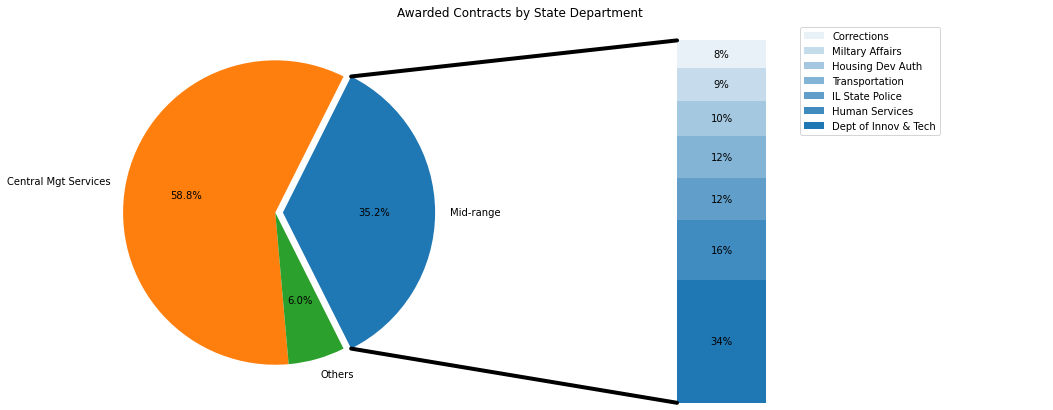

In [50]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_contracts = [.352, .588, .06]
labels = ['Mid-range', 'Central Mgt Services', 'Others']
explode = [0.05, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_contracts[0]
wedges, *_ = ax1.pie(overall_contracts, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
contracts_ratios = [.339, .165, .116, .116,.097, .091,.076]
contracts_labels = ['Dept of Innov & Tech', 'Human Services', 'IL State Police', 'Transportation', 'Housing Dev Auth', 'Miltary Affairs', 'Corrections']
bottom = 1
width = .2

# Adding from the top matches the legend
for j, (height, label) in enumerate(reversed([*zip(contracts_ratios, contracts_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.15 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(contracts_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)


# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)
plt.title('Awarded Contracts by State Department                                                                                                        ')
plt.show()
